In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import h5py
from scipy import optimize

%load_ext autoreload
%autoreload 2

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

# Funzioni utili

In [2]:
def create_filter(medium,NPS): 
    '''
    medium è il segnale atteso, quello senza rumore
    NPS è il noise spectral density
    '''

    val_cal = max(medium)
    S       = np.fft.fft(medium)
    S[0]    = 0+0*1j
    OF_med  = np.fft.ifft(S*S.conjugate()/NPS).real
    K       = val_cal/np.amax(OF_med)  
    H = K*S.conjugate()/NPS   #H è la funzione di trasferimento del filtro, nel dominio delle frequenze

    return H

In [3]:
from scipy.signal import welch

def PSD(esignal_matrix,t_sample,wind = "hann"): 
    '''
    signal_matrix una matrice di eventi di rumore (esignal_matrix) e il tempo di campionamento (t_sample), valuta la PSD
    '''
    wind     = wind
    npt      = esignal_matrix.shape[1]
        
    f, pxx = welch(esignal_matrix,fs=1./t_sample, window=wind, nperseg=npt, scaling='density', axis=1)
    mean_true_scale = np.mean(pxx, axis = 0)
        
    f = np.append( f[:-1], -1*f[1:][::-1])
    mean_true_scale = np.append( mean_true_scale[:-1],  mean_true_scale[1:][::-1] ) 
    mean_use_scale  = mean_true_scale* (1./t_sample*esignal_matrix.shape[1]/2.)    #correct?
        
    return f, mean_use_scale, mean_true_scale

In [4]:
def parabolic_fit(mat,stop=0):

    max_pos = np.argmax(mat[:,stop:-1],axis=1) + stop
    dim     = np.arange(0,mat.shape[0])
    x1 = max_pos-1
    x2 = max_pos
    x3 = max_pos+1
    y1 = mat[dim,x1]
    y2 = mat[dim,x2]
    y3 = mat[dim,x3]
    a  = (x1*(y3-y2) + x2*(y1-y3)+x3*(y2-y1) )  / ( (x1-x2)*(x1-x3)*(x2-x3)   )
    b  = (y2-y1)/(x2-x1)-a*(x1+x2)
    c  = y1 -a*x1**2 -b*x1

    return a,b,c,max_pos

In [5]:
def applyOF(esignal_matrix,H):
    
    events_OF_f = np.fft.fft(esignal_matrix, axis=1)*H
    OFF         = np.array(np.sum(np.abs(events_OF_f), axis=1)/esignal_matrix.shape[1]) 
    events_OF   = np.fft.ifft(events_OF_f).real
    events_OF   = np.concatenate((events_OF[:,int(esignal_matrix.shape[1]/2):esignal_matrix.shape[1]], events_OF[:,0:int(esignal_matrix.shape[1]/2)]),axis=1)
    a,b,c       = parabolic_fit(events_OF)[0:3]
    OFmax_pos   = np.argmax(events_OF,axis=1)
    OFdelay     = -b/(2.*a)  -esignal_matrix.shape[1]/2
    OFT         = -1.*(b**2)/(4.*a) +c
    del a,b,c, events_OF_f

    OFtest = 1. - OFT/OFF

    return OFT, OFF, OFdelay, OFtest

In [6]:
class Medium():
    '''
    Questa è la classe che permette di definire il segnale atteso dato degli eventi di rumore
    e degli eventi di segnale rumorosi.    
    '''
    
    def __init__(self, medium=None, NPS=None):
        self._medium   = medium # Pulse medium	                                           
        self._NPS      = NPS    # noise power spectrum (compunted in not normalized units) 
        return
    
    def set_NPS(self, NPS):
        # Set Noise Power Spectrum (externally computed) 
        self._NPS = NPS

    def get_NPS(self):
        return self._NPS
    
    def get_medium(self):
        return self._medium

    def set_medium(self, medium):
        self._medium = medium
        return
    
    def create_medium(self, signal_matrix, bsl=None, indexes=None):
        for _ in range(2):
            self.__do_medium(signal_matrix, bsl=bsl, indexes=indexes)
        return
    
    def __do_medium(self, signal_matrix, bsl=None, indexes=None):

        esignal_matrix = (signal_matrix.T - bsl).T if indexes is None else (signal_matrix[indexes].T - bsl[indexes]).T 
        
        S_omega = np.fft.fft(esignal_matrix, axis=1)
        S_omega[:,0] = np.zeros(esignal_matrix.shape[0])        #WHY?

        if self._medium is None:	
            S_cc = S_omega[0,:].conjugate()
        else: 
            S_cc = np.fft.fft(self._medium).conjugate()
            S_cc[0] = 0.
            								  			 

        K   = 1.                                         
        H   = K * (S_cc/self._NPS)
        OFT = np.fft.ifft(S_omega*H).real
        OFT = np.concatenate((OFT[:,int(esignal_matrix.shape[1]/2):esignal_matrix.shape[1]], OFT[:,0:int(esignal_matrix.shape[1]/2)]), axis=1)

        delay_ref = int(esignal_matrix.shape[1]/2.)
        time      = np.arange(esignal_matrix.shape[1])
        a,b       = parabolic_fit(OFT)[0:2]

        max_pos_true = -b/(2*a)
        delay        = max_pos_true - delay_ref
        del a,b, max_pos_true
        
        for i in range(esignal_matrix.shape[0]):
            esignal_matrix[i,:] = np.interp(time+delay[i],time, esignal_matrix[i,:])
        
        self._medium = np.mean(esignal_matrix,axis=0)
        
        return

# Calcolo il filtro ottimo

In [7]:
from scipy.signal import savgol_filter

In [8]:
def trigger(signals,final,th):
    '''First derivative triger on minimum'''
    for data in signals:  
        win = 100  # Size of the moving average window
        cumsum = np.cumsum(data)
        moving_avg = np.array((cumsum[win:] - cumsum[:-win]) / win)
        moving_avg = np.pad(moving_avg, (win - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))
        polyorder = 5
        sav_size = 100
        sg_filtered_signal = savgol_filter(moving_avg, sav_size, polyorder)
        st = savgol_filter(sg_filtered_signal,100,5,1)
        ymin = min(st)
        if ymin<-th*1e-6:
            final.append(data)
    return final


In [9]:
import os
path = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\DATA ANALYSIS\OPTIMUM\COMPLETE_RUNS\\'
noises, signals = [], []
for filename in os.walk(path):
    for file in filename[2]:
            with h5py.File(path+file,'r') as file:
                for key in file.keys():
                    if 'Noise' in key:
                        noises.append(np.array(file[key][:]))
                    elif 'Raw' in key:
                        signals.append(np.array(file[key][:])[:20000])

In [10]:
final = []
final = trigger(signals,final,8)

In [11]:
preStop = 950  #E' il numero di punti della finestra di acquisizione senza il segnale.
signal_matrix = np.array(final)
noise_matrix = np.array(noises[:len(signal_matrix)])

In [12]:
bsl = np.mean(signal_matrix[:,0:preStop],axis=1)
bsl_noise = np.mean(noise_matrix,axis=1)

#Faccio in modo tale che i dati e il rumore partano da 0

signal_matrix = -1*(signal_matrix - np.array([bsl]).T ) 
noise_matrix = -1*(noise_matrix - np.array([bsl_noise]).T)

In [47]:
# Calcolo la PSD del rumore, il primo ingrediente del filtro ottimo
t_samp = 1/1e8   #in secondi

freq_noise, PSD_noise, _ = PSD(noise_matrix[:,:noise_matrix.shape[1]],t_samp)
freq_sig, PSD_sig, _ = PSD(np.array([signal_matrix[1]]),t_samp)

npt_noise = PSD_noise.shape[0]
npt_sig = PSD_sig.shape[0]

In [53]:
with open('PSD.txt','w')as f:
    for noi in PSD_noise:
        f.writelines(str(noi)+'\n')

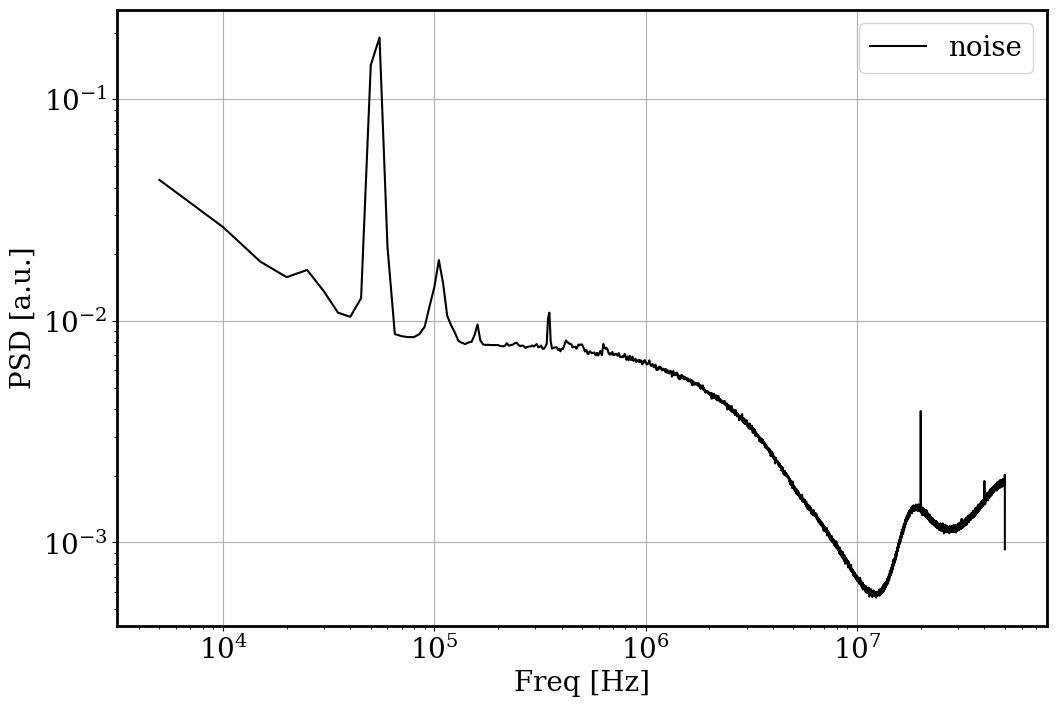

In [51]:
plt.loglog(-1*freq_noise[npt_noise//2:][::-1],PSD_noise[npt_noise//2:][::-1],c='k',label='noise')
plt.loglog(-1*freq_sig[npt_sig//2:][::-1],PSD_noise[npt_sig//2:][::-1],c='b',label='signal')
plt.xlabel("Freq [Hz]")
plt.ylabel("PSD [a.u.]")
plt.legend()
plt.grid()
plt.show()

In [14]:
# Calcolo il segnale atteso (medio), l'ultimo ingrediente per il filtro ottimo

medium = Medium(NPS = PSD_noise)
medium.create_medium(signal_matrix,np.zeros(signal_matrix.shape[0]))
medium_pulse = medium.get_medium()

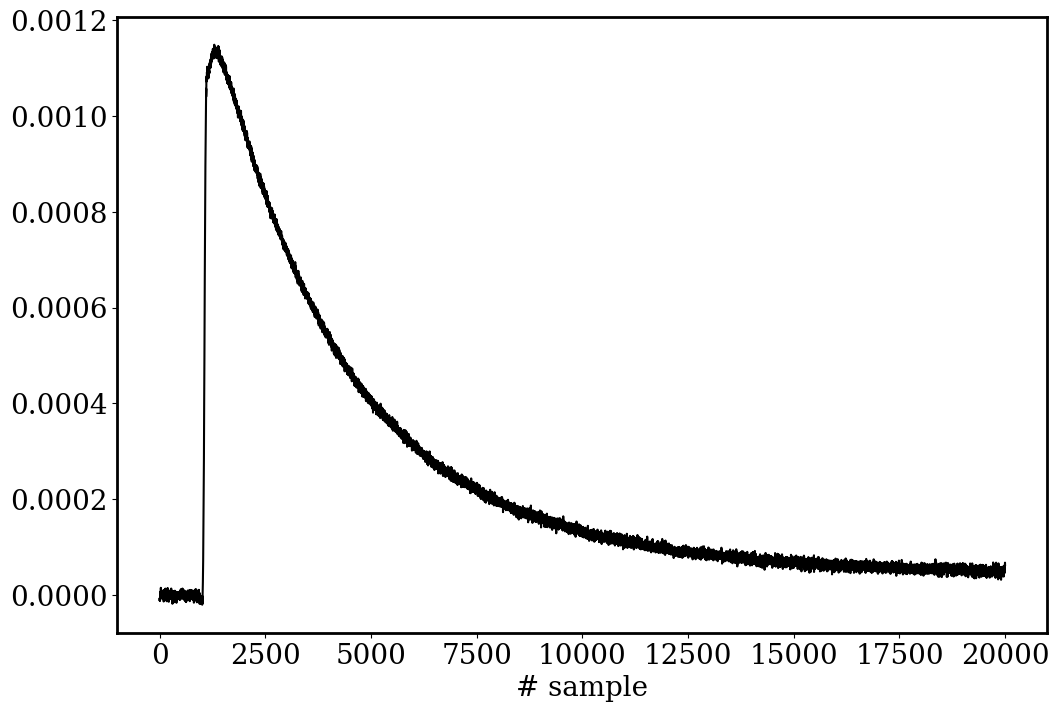

In [15]:
plt.plot(medium_pulse,c='k')
plt.xlabel("# sample")
plt.show()

In [16]:
# Creo il filtro H e lo applico ai dati su cui ho calcolato il medio
H = create_filter(medium_pulse,PSD_noise)

signal_matrix_filtered_f =  np.fft.fft(signal_matrix, axis=1)*H # dati filtrati dominio freq
signal_matrix_filtered_t =  np.fft.ifft(signal_matrix_filtered_f).real   #dati filtrati dominio temp
signal_matrix_filtered_t =  np.concatenate((signal_matrix_filtered_t[:,int(signal_matrix_filtered_t.shape[1]/2):signal_matrix_filtered_t.shape[1]], signal_matrix_filtered_t[:,0:int(signal_matrix_filtered_t.shape[1]/2)]),axis=1)

noise_matrix_filtered_f =  np.fft.fft(noise_matrix, axis=1)*H # dati filtrati dominio freq
noise_matrix_filtered_t =  np.fft.ifft(noise_matrix_filtered_f).real   #dati filtrati dominio temp
noise_matrix_filtered_t =  np.concatenate((noise_matrix_filtered_t[:,int(noise_matrix_filtered_t.shape[1]/2):noise_matrix_filtered_t.shape[1]], noise_matrix_filtered_t[:,0:int(signal_matrix_filtered_t.shape[1]/2)]),axis=1)

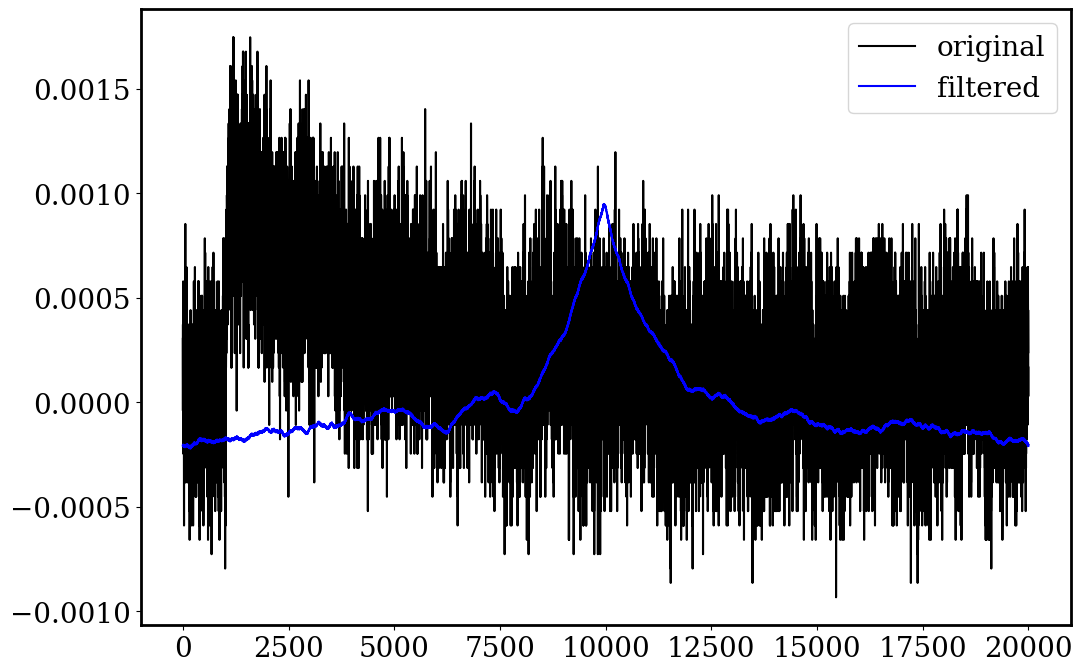

In [17]:
#Guardo come cambiano i dati prima e dopo il filtro ottimo
nev = 10
#===================
plt.plot(signal_matrix[nev],c='k',label="original")
plt.plot(signal_matrix_filtered_t[nev],label="filtered",c='b')
plt.legend()
plt.show()

In [18]:
with open('Filter.txt','w') as f:
    for h in H:
        f.writelines(str(h.real)+'\t'+str(h.imag)+'\n')

# Applico il filtro ottimo per valutare l'ampiezza dei dati

In [19]:
OFT, OFF, OFdelay, OFtest = applyOF(signal_matrix,H)

# OFT è l'ampiezza del segnale, calcolata con il filtro ottimo nel dominio del tempo
# OFF è l'ampiezza del segnale, calcolata con il filtro ottimo nel dominio delle frequenze, dovrebbe essere uguale
#     (o molto simile) a OFT
# OFdelay e OFtest ignoratele.

In [20]:
from iminuit.cost import LeastSquares
from iminuit import Minuit
from scipy.stats import poisson,norm

In [21]:
def model(OFF, N, Lambda, shift, sigma):
    egamma = 0.8  # Photon energy in eV, adjust as needed
    res = np.zeros_like(OFF)  # Initialize result array with zeros

    for n in range(N + 1):  # Ensure to include N in the sum
        k = n * egamma + shift
        # Compute the probability density function (PDF) for the Gaussian distribution
        gaussian_values = norm.pdf(OFF, loc=k, scale=sigma)
        # Compute the Poisson probability mass function (PMF) for the number of photons
        poisson_values = poisson.pmf(n, Lambda)
        # Accumulate the weighted Gaussian values
        res += poisson_values * gaussian_values

    return res

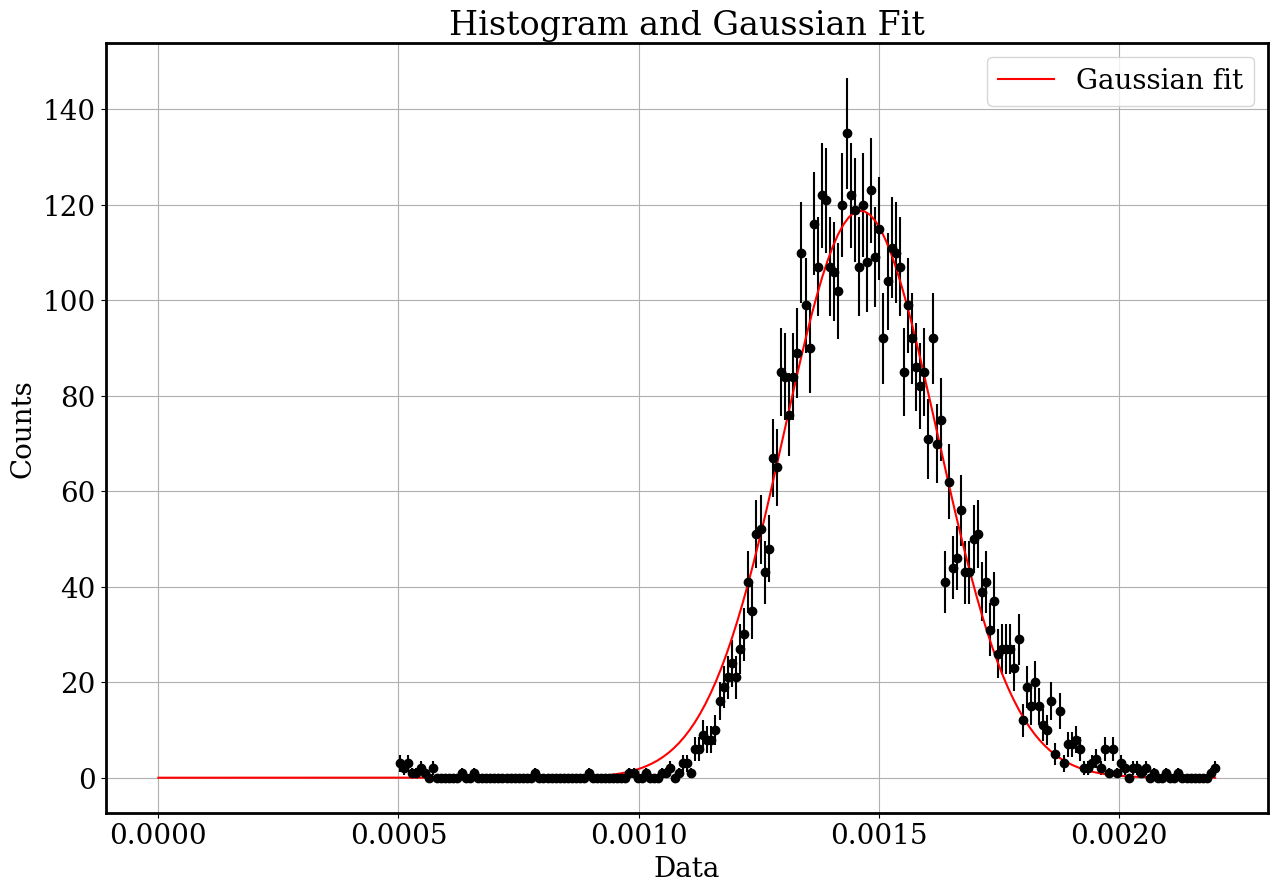

Fitted parameters: Amplitude = 118.77818285200343, Mean = 0.0014622363859382284, Stddev = 0.00015998693975931413


In [46]:
from scipy.optimize import  curve_fit
bins = 200  # Number of bins
hist, bin_edges = np.histogram(OFF, bins=bins, density=False)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Initial guess for the parameters (amplitude, mean, stddev)
initial_guess = [120, 0.0015, 0.005]

# Perform the Gaussian fit
params, covariance = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

# Extract the parameters
amplitude, mean, stddev = params

# Step 4: Plot the histogram and the Gaussian fit
plt.figure(figsize=(15, 10))

# Plot histogram
#plt.hist(OFF, bins=bins, density=False, alpha=0.6, color='blue',edgecolor='black', label='Histogram');
plt.errorbar(bin_centers,hist,np.sqrt(hist),fmt='ko')

x_values = np.linspace(0, max(bin_centers), 200)
plt.plot(x_values, gaussian(x_values, amplitude, mean, stddev), 'r-', label='Gaussian fit')

# Add labels and legend
plt.title('Histogram and Gaussian Fit')
plt.xlabel('Data')
plt.ylabel('Counts')
plt.legend()
plt.grid()
# Show plot
plt.show()

# Print the fit parameters
print(f"Fitted parameters: Amplitude = {amplitude}, Mean = {mean}, Stddev = {stddev}")

In [54]:
print(np.sum(hist))

5634


In [23]:
import numpy as np
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import poisson, norm

def compute_sum_poisson_gaussian(amplitudes, A, mu, shift, sigma, Egamma):
    """
    Compute the sum over n of P(n; µ)·G(OFF; nEγ + shift; σ)
    
    Parameters:
    - amplitudes: Array of measured amplitudes (OFF).
    - N: Maximum number of photons to consider.
    - mu: Mean of the Poisson distribution.
    - shift: Offset for the Gaussian distribution.
    - sigma: Standard deviation of the Gaussian distribution.
    - Egamma: Energy of a single photon.
    
    Returns:
    - Array of computed values for the given amplitudes.
    """
    # Initialize result array
    result = np.zeros_like(amplitudes)

    N = 20
    
    # Array of possible photon numbers
    photon_numbers = np.arange(0, N+1, dtype=int)
    
    # Compute Poisson probabilities for all photon numbers
    poisson_probs = poisson.pmf(photon_numbers, mu)
    
    # Compute the Gaussian PDF for each photon number and sum up
    for i, n in enumerate(photon_numbers):
        # Compute Gaussian PDF for the current number of photons
        gaussian_values = norm.pdf(amplitudes, loc=n * Egamma + shift, scale=sigma)
        
        # Update result array
        result += poisson_probs[i] * gaussian_values
    
    return A * result

In [24]:
# Example parameters
A = 10
mu = 0.01  # Mean of the Poisson distribution
shift = 0.01  # Offset for the Gaussian distribution
sigma = 0.002  # Standard deviation of the Gaussian distribution
Egamma = 0.8  # Energy of a single photon in eV

# Example data (replace with your actual amplitude data)
amp_values = OFF  # Array of amplitude values

# Compute the model values
model_values = compute_sum_poisson_gaussian(amp_values, A, mu, shift, sigma, Egamma)

In [37]:
p0 = [A, mu, shift, sigma, Egamma]

In [38]:
from scipy.optimize import curve_fit

# Fit the model to the data using curve_fit
popt, pcov = curve_fit(compute_sum_poisson_gaussian, bin_centers, hist)

# Extract fitted parameters
A_fit, N_fit, mu_fit, shift_fit, sigma_fit, Egamma_fit = popt

# Print the fitted results
print(f"Fit results: A = {A_fit}, N = {int(N_fit)}, mu = {int(mu_fit)}, shift = {shift_fit}, sigma = {sigma_fit}, Egamma = {Egamma_fit}")

# Generate the model values using the fitted parameters
model_values = compute_sum_poisson_gaussian(bin_centers, A_fit, int(N_fit), int(mu_fit), shift_fit, sigma_fit, Egamma_fit)

# Plot the data and the fitted model
plt.figure(figsize=(10, 6))
plt.hist(amp_values, bins=200, density=True, alpha=0.5, label='Data')
plt.plot(bin_centers, model_values, color='red', label='Fitted Model')
plt.xlabel('Amplitude')
plt.ylabel('Density')
plt.title('Histogram and Fitted Model')
plt.legend()
plt.grid(True)
plt.show()

ValueError: not enough values to unpack (expected 6, got 5)

In [ ]:
from scipy.optimize import curve_fit

# Example histogram data
hist_values, bin_edges = np.histogram(amp_values, bins=100, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Initial guess
p0 = [1, 100, 10, 0.01, 0.0002, 0.002]

# Fit the model to the data using curve_fit
popt, pcov = curve_fit(compute_sum_poisson_gaussian, bin_centers, hist_values, p0=p0)

# Extract fitted parameters
A_fit, N_fit, mu_fit, shift_fit, sigma_fit, Egamma_fit = popt

# Convert to integers where needed
N_fit = int(N_fit)
mu_fit = int(mu_fit)

# Print the fitted results
print(f"Fit results: A = {A_fit}, N = {N_fit}, mu = {mu_fit}, shift = {shift_fit}, sigma = {sigma_fit}, Egamma = {Egamma_fit}")


Fit results: A = 24.641222052759918, N = 100, mu = 12, shift = 0.010462787582695041, sigma = 2.6170083248494883e-06, Egamma = 0.0019959828149426575
